In [1]:
# Import lybraries
import math
import numpy as np

from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d.art3d import Line3DCollection
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from typing import Iterable, Optional

# GLACIER SIMULATOR

In [2]:
# Sets All desired variables for the symulation
N = 1000000 # number of particles
a = 30 # cm lenght of the scintillator bars
b = 4  # cm width of the scintillator bars
s = 1  # cm height of the scintillator bars
c = 5  # cm distance between two top layers

First step: generating all starting points.

***HP1:*** incoming particles are uniformly distributed and are counted only if they can pass through all 3 detectors.

We should start to focus on generating all possible particles from a rectangular "source", with known acceptance, above the detector. This is simpler than generating all possible incoming directions coming from the sky.

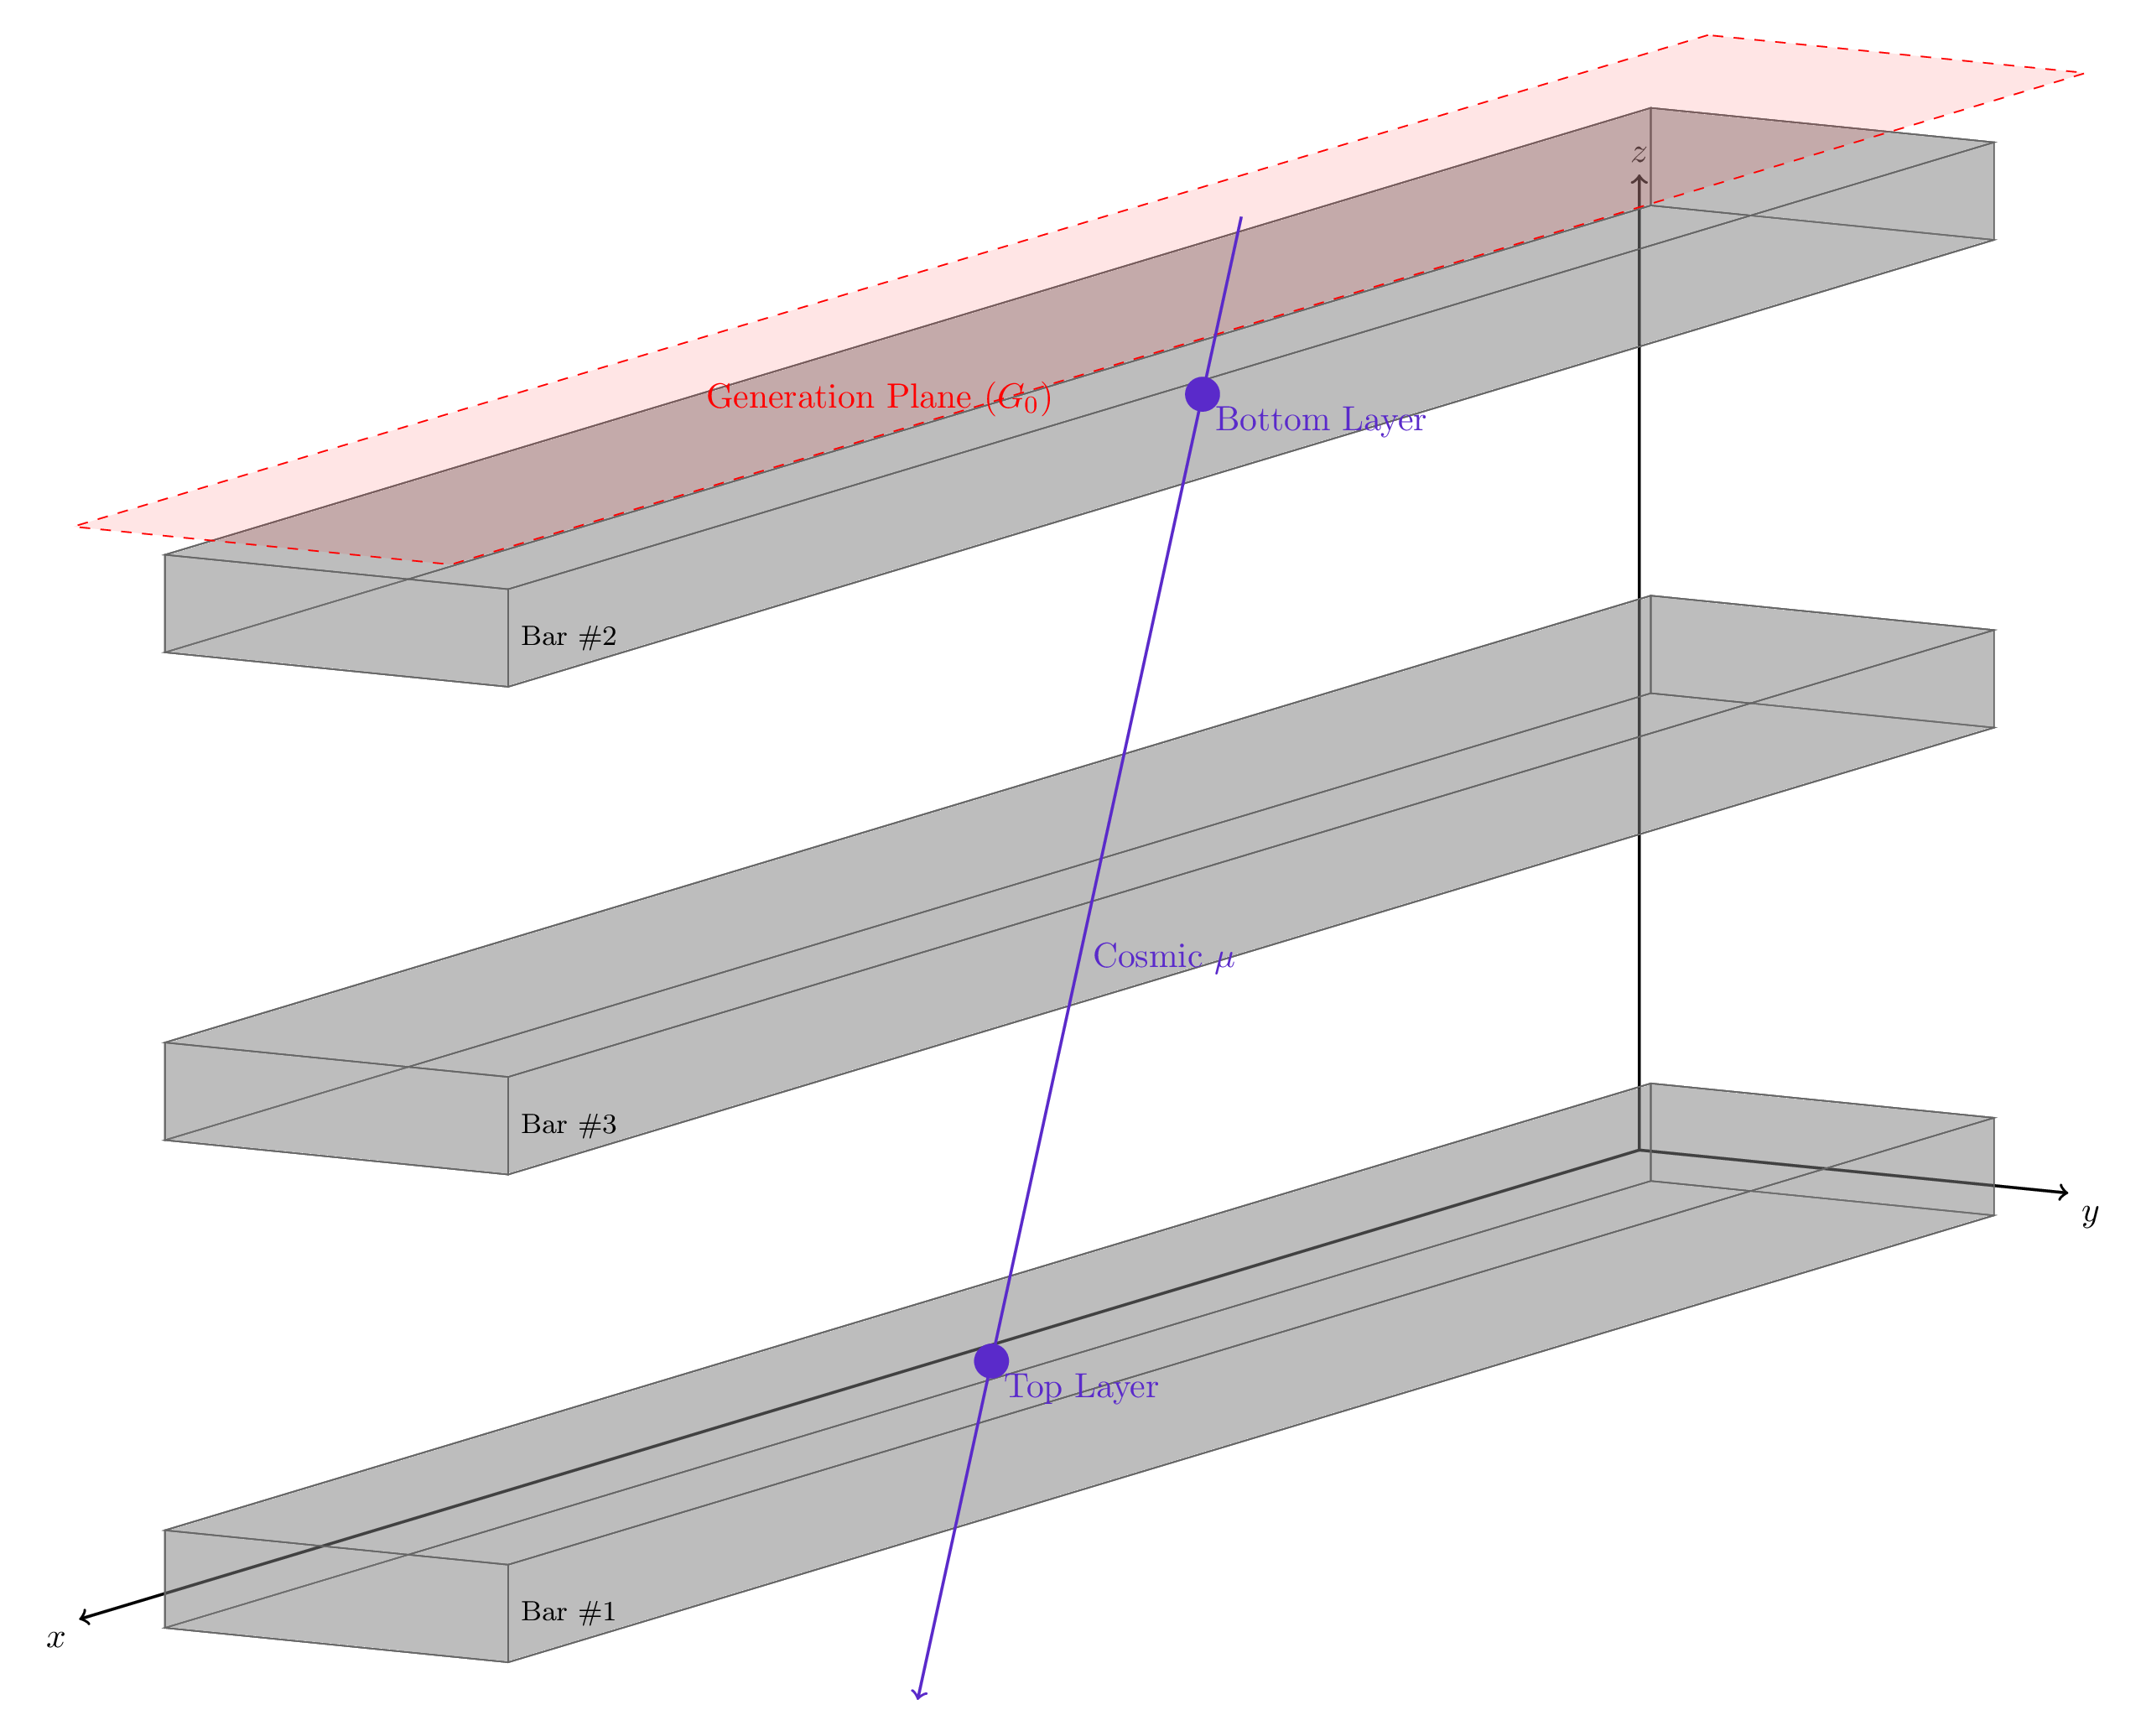

We count particles which passed from the bottom layer of the top bar and the top layer of the bottom one, in order to keep the muons which went through the sides.
#### Acceptance
GLACIER's acceptance is defined in the following way:
$$G = G_0 \cdot \frac{N_{hits}}{N_{gen}}$$
where $$G_0 = \pi (a+2dx)(b+2dy)$$ is the generation layer's acceptance.



In [3]:
# Sets the generation layer above GLACIER in z0. It is larger than the scintillators.
dx = 0.05*a
dy = 0.05*b
z0 = 2*c*1.05

# Known acceptance of a plane rectangle
G0 = np.pi*(a+2*dx)*(b+2*dy)

# Generates all particles positions
x = np.array(np.random.rand(N))*(a+2*dx)
y = np.array(np.random.rand(N))*(b+2*dy)
z = np.array([2*c, c, 0.])

In [4]:
# Function that can generate GLACIER plot: returns the figure object, the ax and the index of all plotted points
def plot_GLACIER(
    x: np.ndarray, # x position of the points
    y: np.ndarray, # y position of the points
    sample_idx: Optional[Iterable[int]] = None, # index of plotted points
    a: float = 30., # cm lenght of the scintillator bars
    b: float = 4., # cm width of the scintillator barss
    c: float = 5., # cm distance between two top layers
    s: float = 1., # cm height of the scintillator bars
    z_levels: tuple[float, float, float] = (0.0, 5.0, 10.0), # default spacing between planes
    figsize: tuple[float, float] = (8, 8),
    title: str = "GLACIER"):

    x = np.asarray(x)
    y = np.asarray(y)
    assert x.shape == y.shape, "x and y must have the same shape"
    N = len(x)

    # Plots only a subsample of the given points
    if sample_idx is not None:
        idx = np.array(list(sample_idx), dtype=int)
    else:
        # if the sample index is not set it gets the min between 250 and half the square root of N
        sample_size = min(int(np.sqrt(N)/2.), 250)
        rng = np.random.default_rng()
        idx = rng.choice(N, size=sample_size, replace=False)
    xs, ys = x[idx], y[idx]
    z_top = float(np.max(z_levels)*1.05)
    dx = 0.05*a
    dy = 0.05*b
    xlim = (dx, a+dx)
    ylim = (dy, b+dy)

    # Draws GLACIER
    Charm_colors = ["#0000FF", "#00FF00", "#FF0000"]
    fig = plt.figure(figsize=figsize)
    ax = fig.add_subplot(111, projection="3d")
    for z, c in zip(z_levels, Charm_colors):
        if z == np.max(z_levels)*1.05:
            verts = [[
            (xlim[0]-dx, ylim[0]-dy, z),
            (xlim[1]+dx, ylim[0]-dy, z),
            (xlim[1]+dx, ylim[1]+dy, z),
            (xlim[0]-dx, ylim[1]+dy, z),
            ]]
        else:
            verts = [[
            (xlim[0], ylim[0], z),
            (xlim[1], ylim[0], z),
            (xlim[1], ylim[1], z),
            (xlim[0], ylim[1], z),
            ]]
        poly = Poly3DCollection(verts, facecolors=c, alpha=0.5,  linewidths=0.5)
        ax.add_collection3d(poly)

    # Adds the sampled points
    ax.scatter(xs, ys, np.full_like(xs, z_top), s=20)
    ax.set_title(title, fontweight='bold', fontsize=22)
    ax.set_xlabel("x [cm]", fontweight='bold', fontsize=18)
    ax.set_ylabel("y [cm]", fontweight='bold', fontsize=18)
    ax.set_zlabel("z [cm]", fontweight='bold', fontsize=18)
    ax.set_xlim(-2., max(np.max(x), np.max(y)))
    ax.set_ylim(-2., max(np.max(x), np.max(y)))
    dz = (max(z_levels) - min(z_levels)) * 0.1
    ax.set_zlim(min(z_levels) - dz, max(z_levels) + dz)
    plt.show()

    return fig, ax, idx

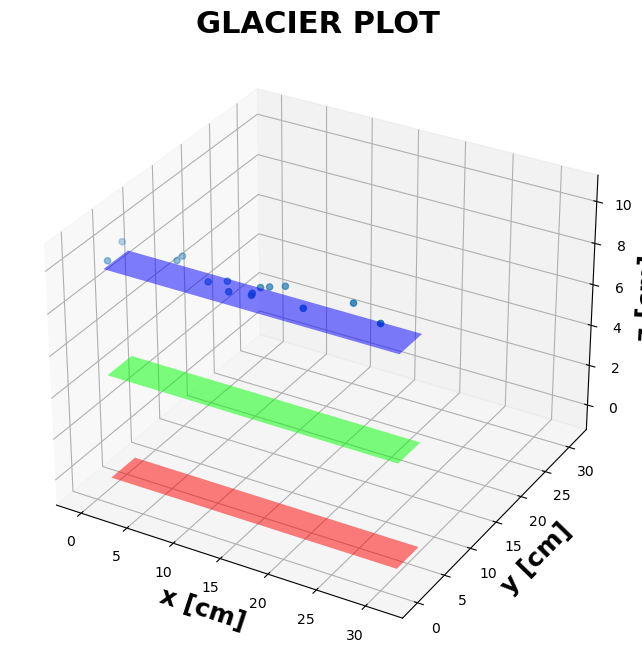

In [5]:
fig, ax, idx = plot_GLACIER(x, y, z_levels=z, sample_idx=np.arange(0,15,1), title="GLACIER PLOT")

Now we need to define the direction of each incoming particle.

Given the vector: $$\vec{v}=\left(l, m, n\right)=\left(sinθcosϕ, sinθsinϕ, cosθ\right)\text{ with }\theta\in\left[0,\frac{\pi}{2}\right],\, \phi\in\left[0,2\pi\right[$$

we can define the parametric line:
$$ \left\{\begin{matrix}
x-x_{0}=t\cdot l \\
y-y_{0}=t\cdot m \\
z-z_{0}=t\cdot n
\end{matrix}\right.$$

In [6]:
# Generates the direction of the incoming particles
theta = np.array(np.random.rand(N)*np.pi/2.)
phi = np.array(np.random.rand(N)*2*np.pi)

# Defines the vector of the 3D-line (particle direction)
l = np.sin(theta)*np.cos(phi)
m = np.sin(theta)*np.sin(phi)
n = np.cos(theta)

A signal is defined as a particle passing through all 3 detectors. This means hitting the top layer and the bottom layer in any possible way.

In [7]:
# intercept the bottom part of the top-bar
t1 = (2*c-s-z0)/n
x1 = l*t1 + x
y1 = m*t1 + y

# intercept the bottom plane
tf = (z[-1]-z0)/n
xf = l*tf + x
yf = m*tf + y

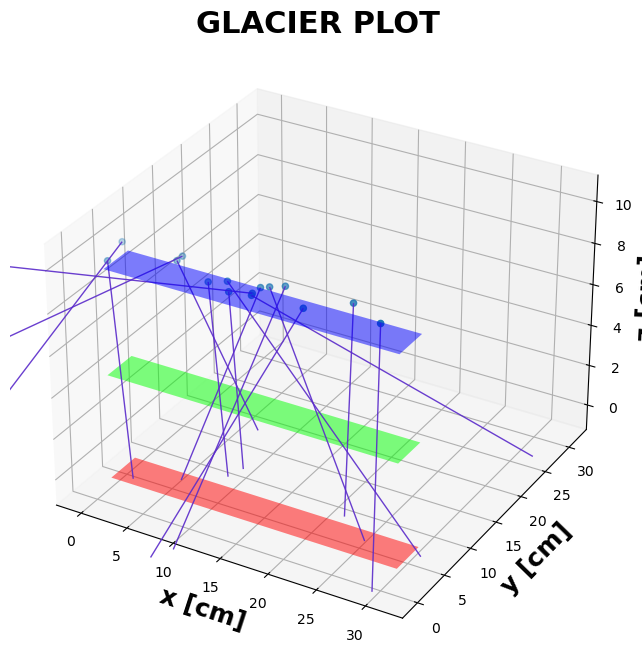

In [8]:
# visualize some incoming particles
segments = [ [(xf[j], yf[j], z[-1]), (x[j], y[j], z0)] for j in idx ]
lc = Line3DCollection(segments, linewidths=1, alpha=0.9, colors="#5A2ACA")
ax.add_collection3d(lc)
display(fig)

In [9]:
signal = np.where((dx<x1) & (x1<a+dx) & (dy<y1) & (y1<b+dy) & (dx<xf) & (xf<a+dx) & (dy<yf) & (yf<b+dy))[0]
print(f"Particle generated: {N}")
print(f"Particle counted:   {len(signal)}")
G = G0 * len(signal)/N
print(f"Angular Coverage: {round(G/(a*b*4*np.pi),2)} %, meaning {round(G/(a*b),2)} str.")
print(f"Acceptance: {round(G,2)} cm^2")

Particle generated: 1000000
Particle counted:   184803
Angular Coverage: 0.06 %, meaning 0.7 str.
Acceptance: 84.3 cm^2
